In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ruptures as rpt
import os
import vaex
from utils import *

In [42]:
%matplotlib inline
plt.rcParams['figure.figsize'] = 30, 10

# Binance data

In [18]:
BINANCE_DATA_PATH = "data/binance/"

In [19]:
from utils import resample_data_vaex

TOP_MKT_CAP = ['BTC', 'ETH', 'BNB', 'XRP', 'DOGE', 'ADA', 'MATIC', 'DOT', 'TRX']

data_raw = {}
data_resampled = {}

for coin in TOP_MKT_CAP:
    data_raw[coin] = vaex.open(os.path.join(BINANCE_DATA_PATH, coin + "-USDT.parquet"))
    data_resampled[coin] = resample_data_vaex(data_raw[coin], freq='D')
    # compute daily log returns
    data_raw[coin]['log_ret'] = np.log(data_raw[coin]['close'] / data_raw[coin]['open'])
    data_resampled[coin]['log_ret'] = np.log(data_resampled[coin]['close'] / data_resampled[coin]['open'])

In [20]:
data_raw['BTC'].head(5)

#,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,open_time,log_ret
0,4261.48,4261.48,4261.48,4261.48,1.77518,7564.91,3,0.075183,320.391,2017-08-17 04:00:00,0
1,4261.48,4261.48,4261.48,4261.48,0,0,0,0,0,2017-08-17 04:01:00,0
2,4280.56,4280.56,4280.56,4280.56,0.261074,1117.54,2,0.261074,1117.54,2017-08-17 04:02:00,0
3,4261.48,4261.48,4261.48,4261.48,0.012008,51.1719,3,0.012008,51.1719,2017-08-17 04:03:00,0
4,4261.48,4261.48,4261.48,4261.48,0.140796,599.999,1,0.140796,599.999,2017-08-17 04:04:00,0


In [21]:
data_resampled['BTC'].head(5)

#,date,open,high,low,close,log_ret
0,2017-08-17,4261.48,4485.39,4200.74,4285.08,0.00552271
1,2017-08-18,4285.08,4371.52,3938.77,4108.37,-0.0421129
2,2017-08-19,4108.37,4184.69,3850,4139.98,0.00766456
3,2017-08-20,4139.98,4211.08,4032.62,4086.29,-0.0130535
4,2017-08-21,4069.13,4119.62,3911.79,4016,-0.0131428


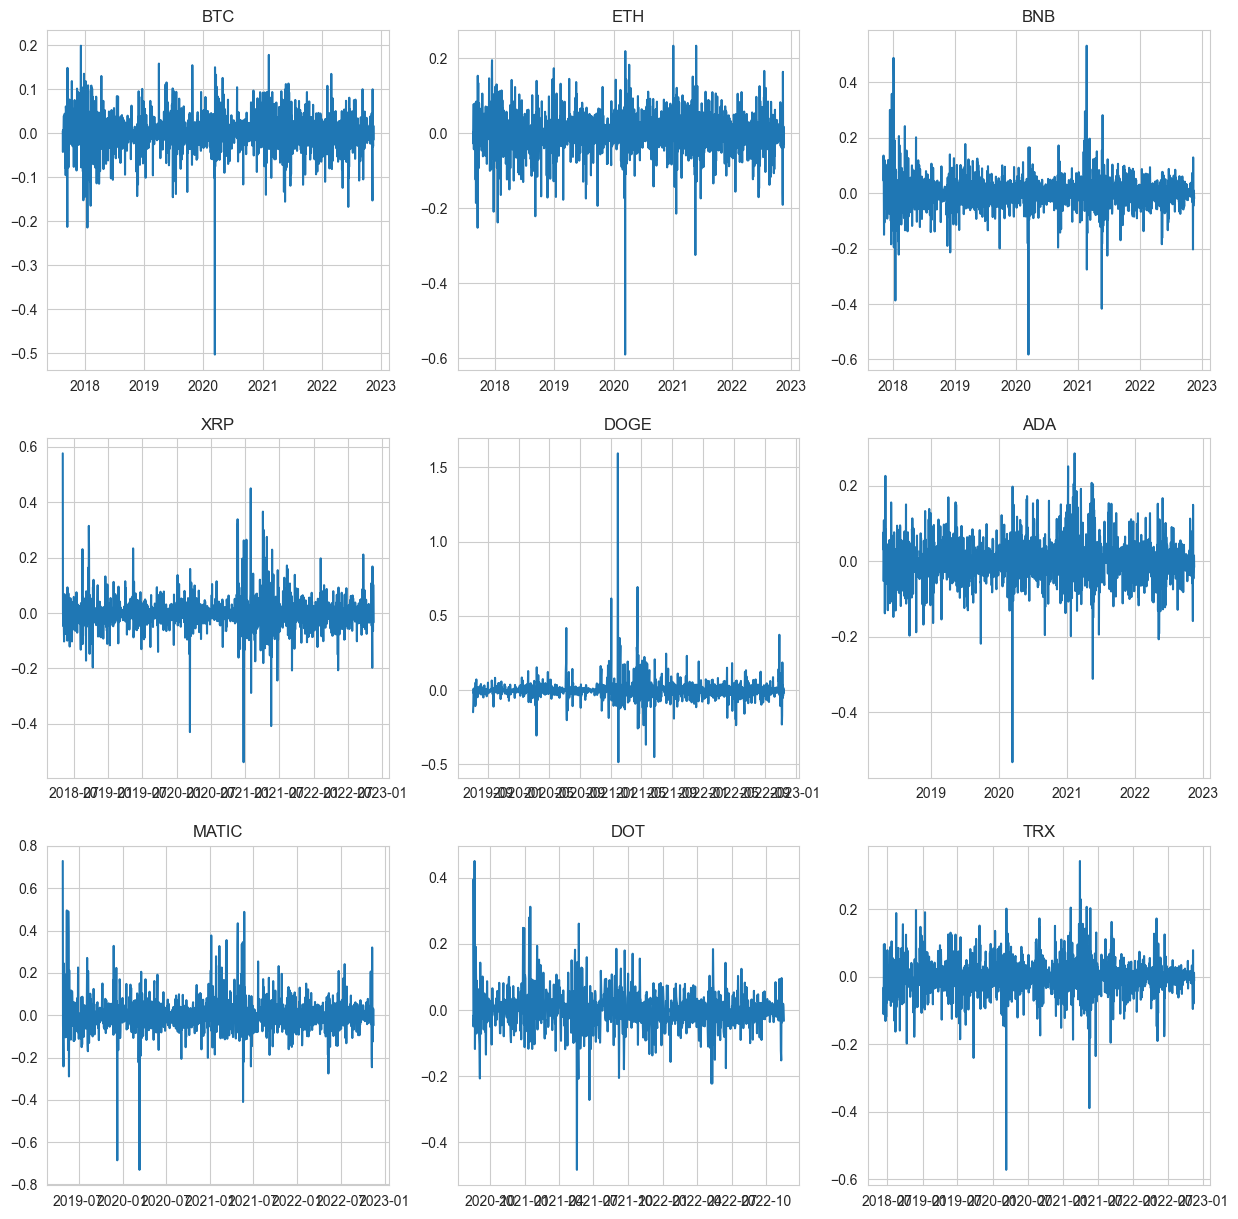

In [22]:
# plot daily log returns
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ax = ax.flatten()
for i, coin in enumerate(TOP_MKT_CAP):
    ax[i].plot(data_resampled[coin]['date'], data_resampled[coin]['log_ret'])
    ax[i].set_title(coin)

# Changepoint Detection

In [49]:
def compute_display_change_points(models, data=data_resampled, coins=TOP_MKT_CAP):

    # Define colors and linestyles for each model
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    linestyles = ['-', ':', '--', '-.']
    
    # Perform change point detection
    for i, coin in enumerate(coins):
        # Fit the models on the log return values
        log_ret_values = data[coin]['log_ret'].to_numpy()
        changepoints_dict = {}
        
        for j, (model_name, model) in enumerate(models.items()):
            # Fit the model on the log return values
            model.fit(log_ret_values)
            # Predict the change points
            changepoints = model.predict(pen=10)
            changepoints_dict[model_name] = changepoints
        
        # Extract dates for plotting
        dates = data[coin]['date'].to_numpy()
        
        # Create the plot
        fig, ax = plt.subplots(figsize=(10, 6))
        # Plot the log returns
        ax.plot(dates, log_ret_values)
        ax.set_title(f'{coin} Change Point Detection')
        ax.set_ylabel('Daily Log Returns')
        ax.set_facecolor('white')  # Set the background color to white
        ax.grid(False)  # Turn off the grid
        
        c = 0
        
        # Highlight the change points
        for model_name, changepoints in changepoints_dict.items():
            for cp in changepoints:
                # Make sure the change point is within the range of the dates array
                if cp < len(dates):
                    # Use a different color and linestyle for each model
                    color = colors[c % len(colors)]
                    linestyle = linestyles[c % len(linestyles)]
                    ax.axvline(dates[cp], color=color, linestyle=linestyle, lw=2, label=model_name)
                    # Print the change point date
                    print(f"Change Point Date for {coin} ({model_name}): {dates[cp]}")
            c += 1
        
        ax.legend()
        plt.show()


/Users/kamilmellouk/opt/anaconda3/envs/ada/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Change Point Date for BTC (PELT-rbf): 2018-04-29
Change Point Date for BTC (BinSeg-rbf): 2018-04-29
Change Point Date for BTC (BinSeg-l2): 2018-04-29


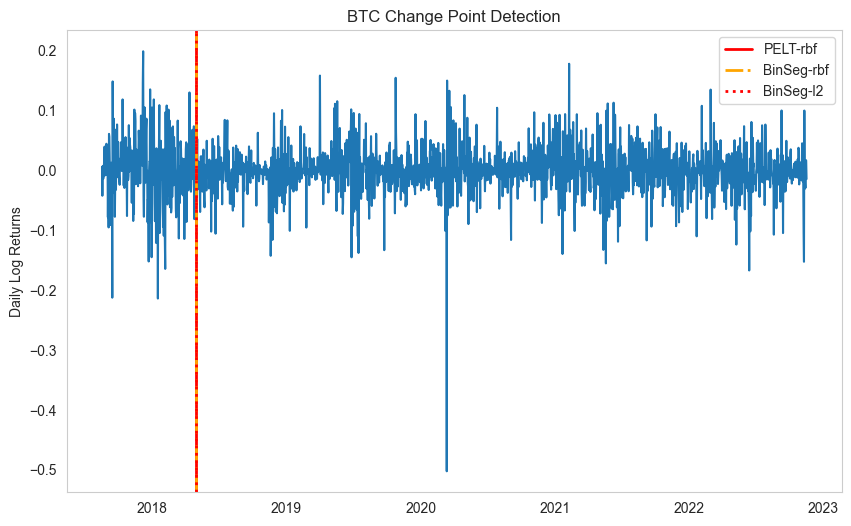

Change Point Date for ETH (PELT-rbf): 2018-04-29
Change Point Date for ETH (BinSeg-rbf): 2018-04-29
Change Point Date for ETH (BinSeg-l2): 2018-04-29


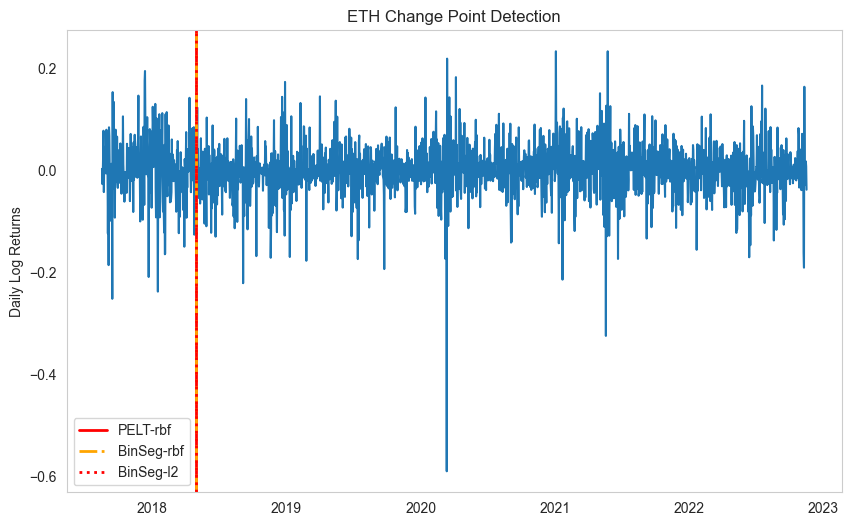

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


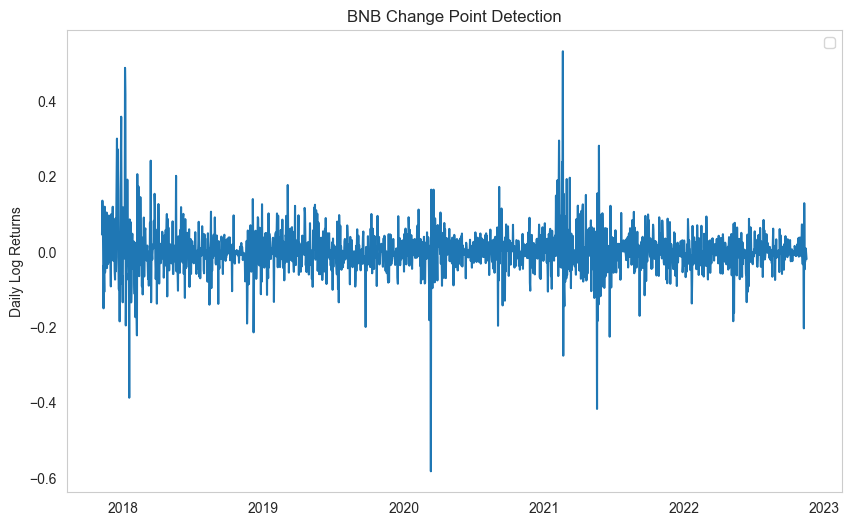

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


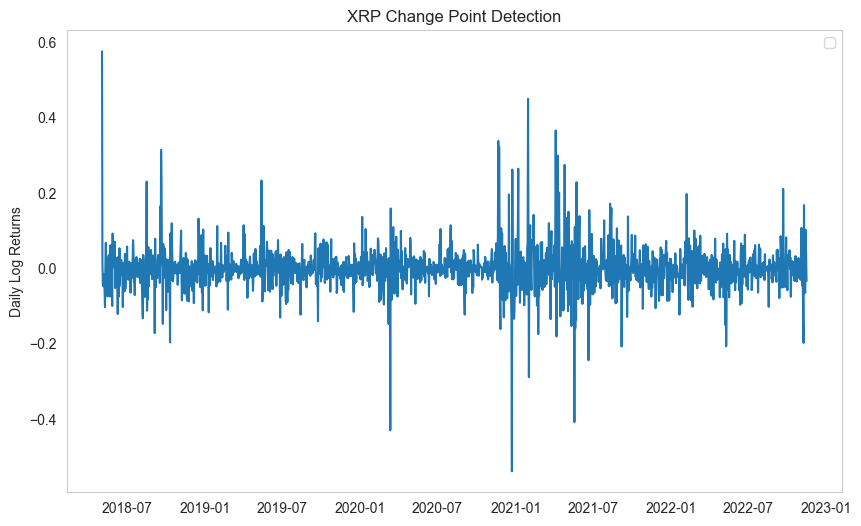

Change Point Date for DOGE (PELT-rbf): 2020-03-16
Change Point Date for DOGE (BinSeg-rbf): 2020-03-16
Change Point Date for DOGE (BinSeg-l2): 2020-03-16


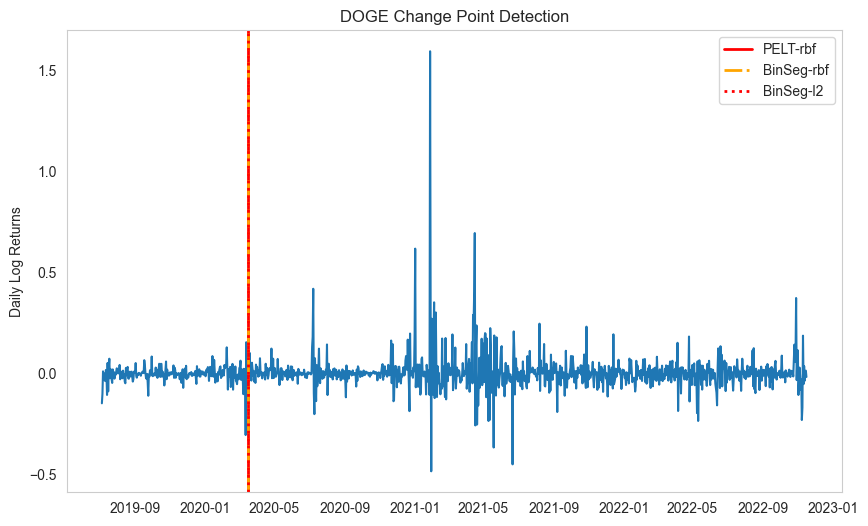

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


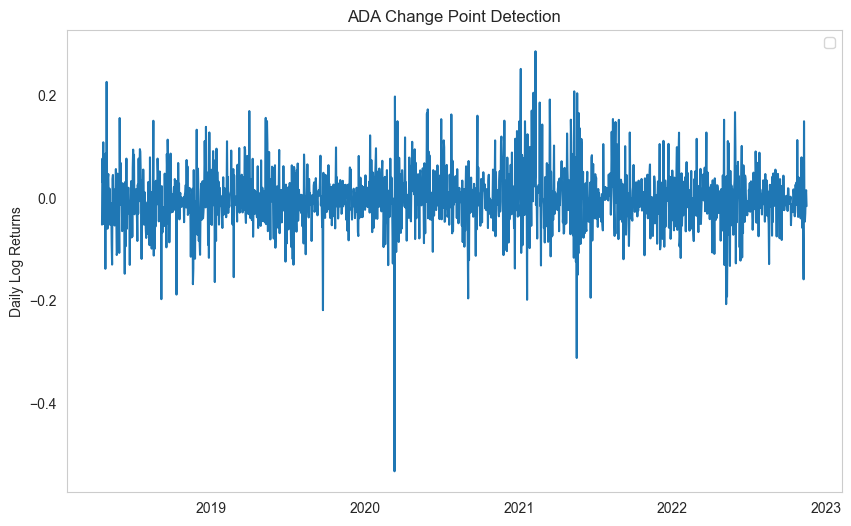

Change Point Date for MATIC (PELT-rbf): 2020-01-06
Change Point Date for MATIC (BinSeg-rbf): 2020-01-06
Change Point Date for MATIC (BinSeg-l2): 2020-01-06


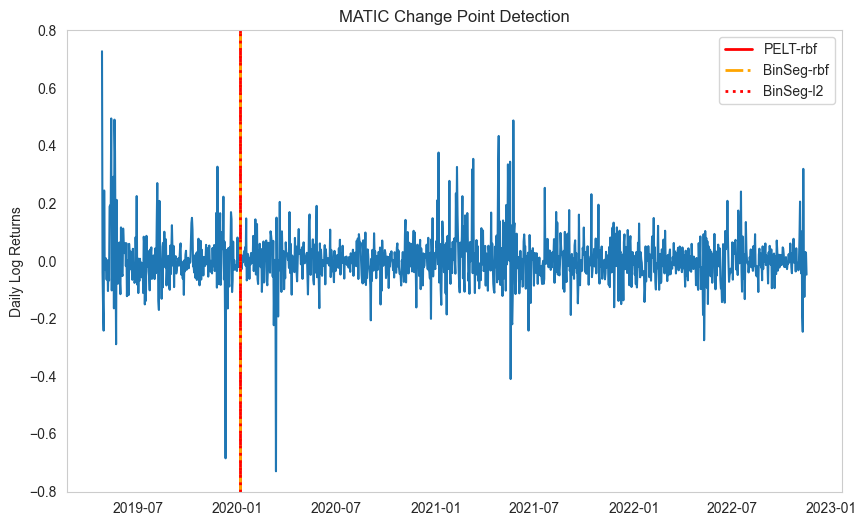

Change Point Date for DOT (PELT-rbf): 2021-04-30
Change Point Date for DOT (BinSeg-rbf): 2021-04-30
Change Point Date for DOT (BinSeg-l2): 2021-04-30


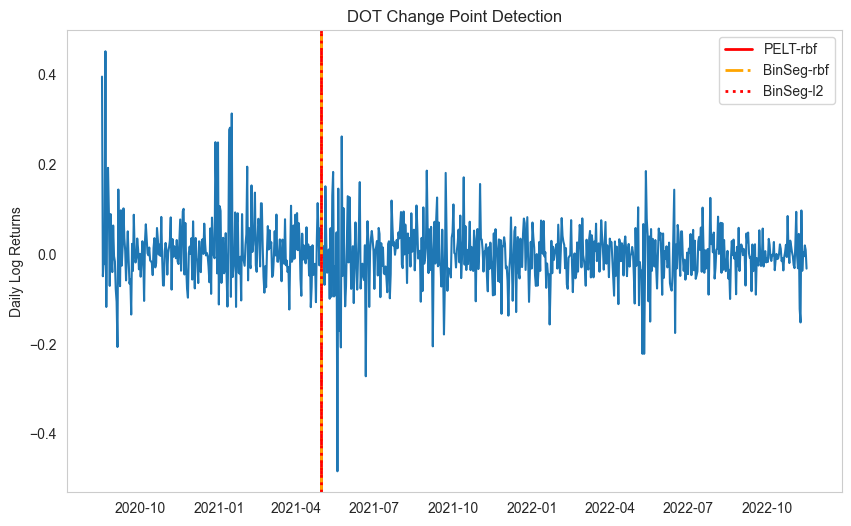

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


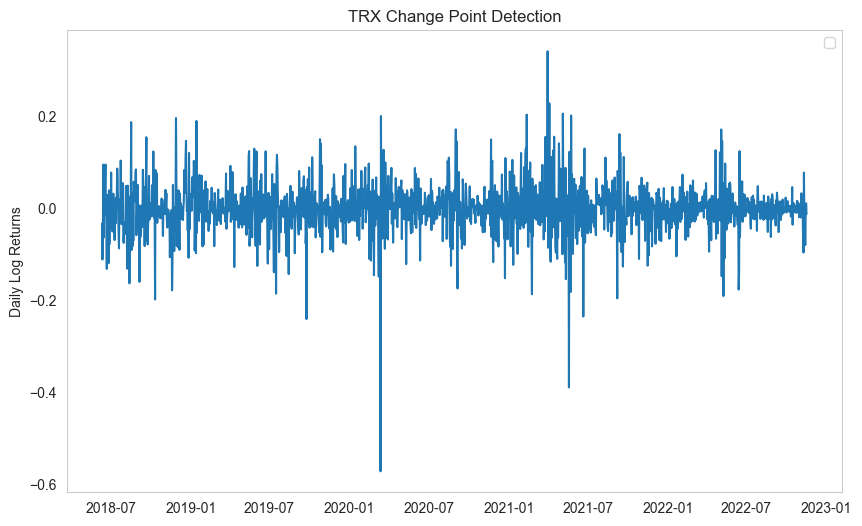

In [52]:
compute_display_change_points({
    'PELT-rbf': rpt.Pelt(model="rbf"),
    'PELT-l1': rpt.Pelt(model="l1"),
    'PELT-l2': rpt.Pelt(model="l2"),
    'BinSeg-rbf': rpt.Binseg(model="rbf"),
    'BinSeg-l1': rpt.Binseg(model="l1"),
    'BinSeg-l2': rpt.Binseg(model="rbf"),

}, data=data_resampled, coins=TOP_MKT_CAP)

##  Pruned Exact Linear Time (PELT)

Change Point Date for BTC: 2018-04-29


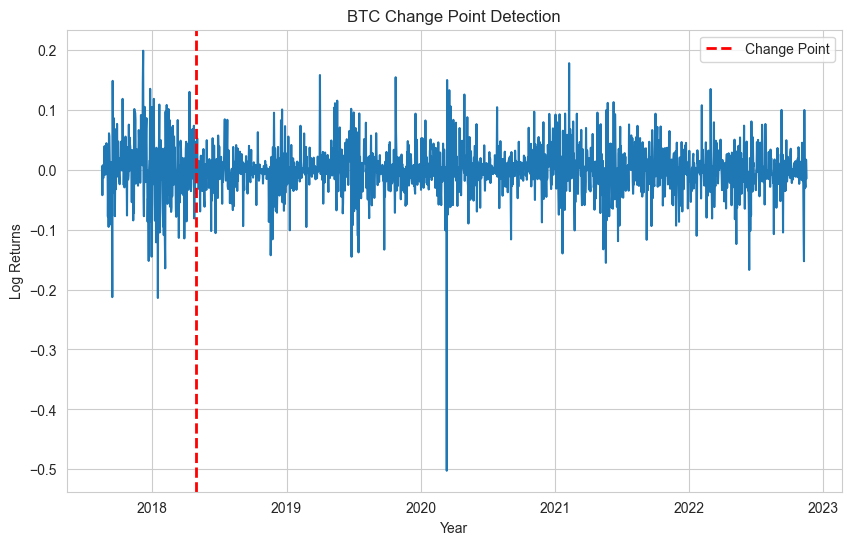

Change Point Date for ETH: 2018-04-29


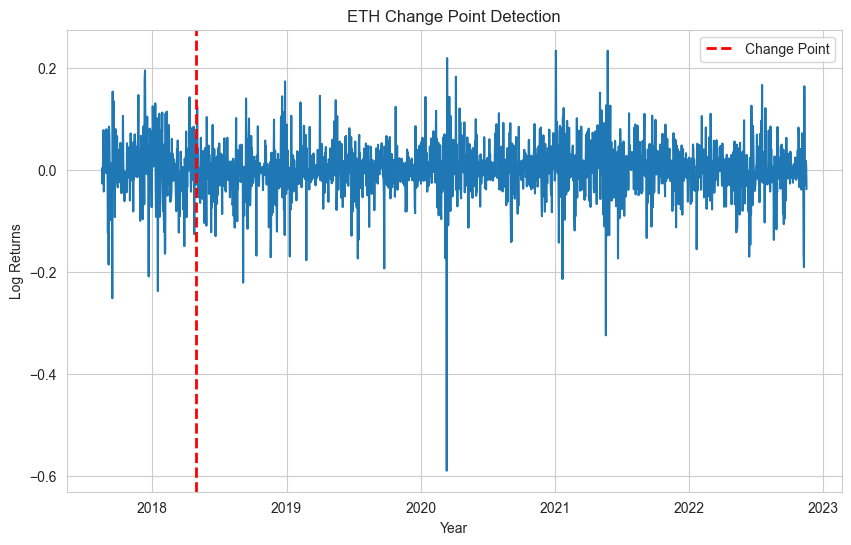

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


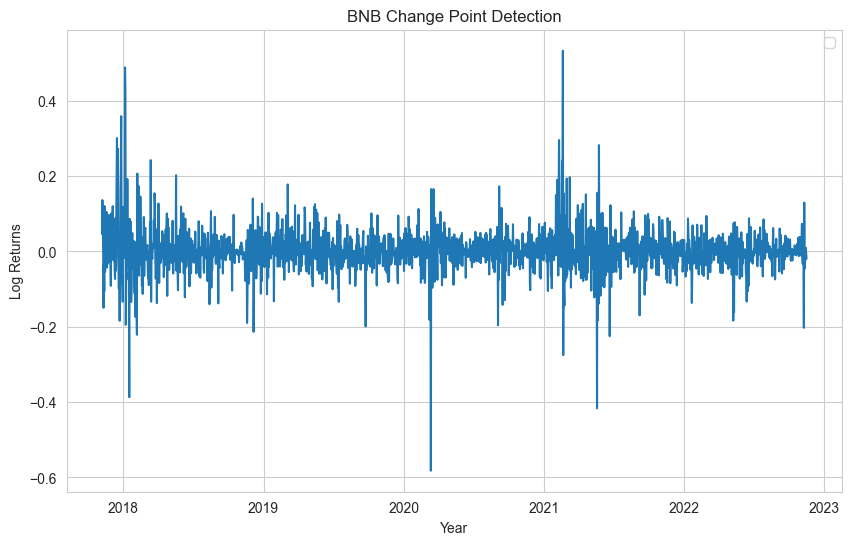

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


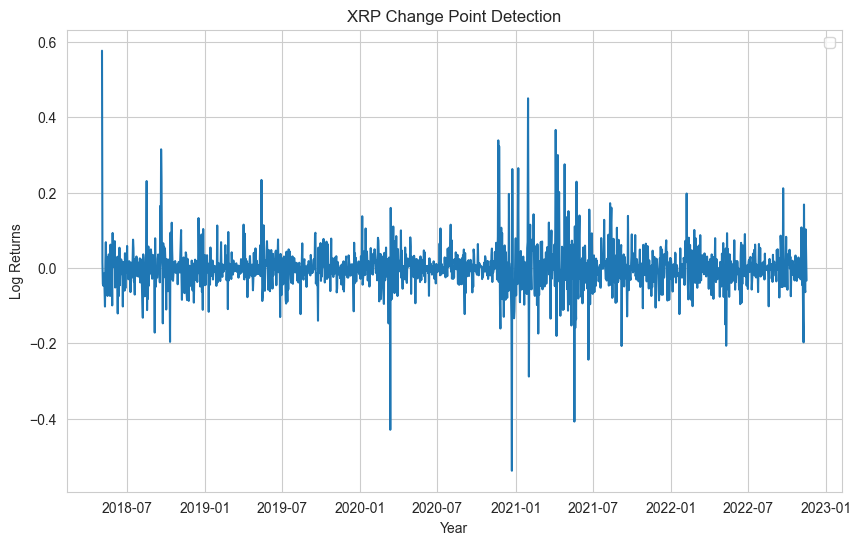

Change Point Date for DOGE: 2020-03-16


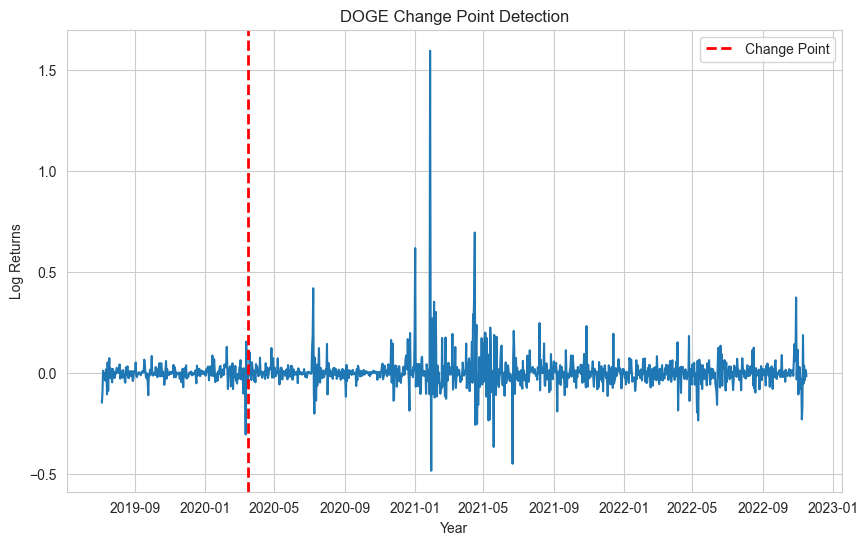

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


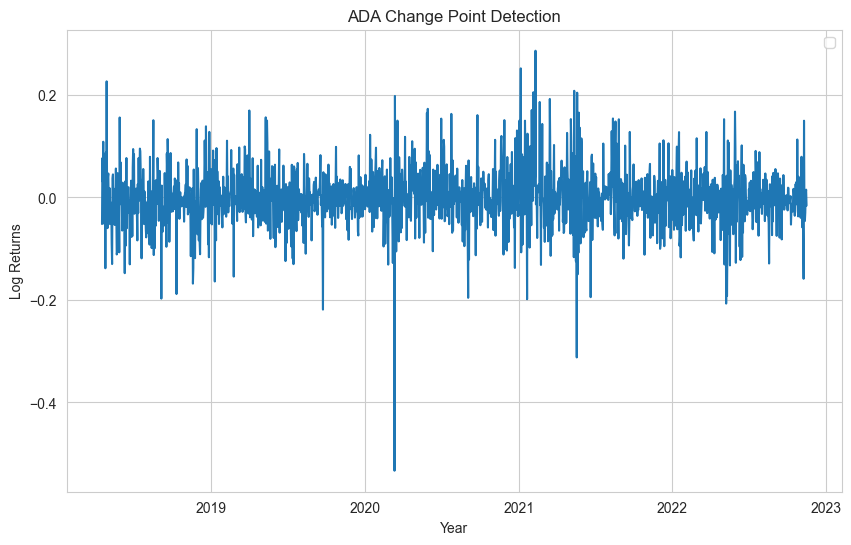

Change Point Date for MATIC: 2020-01-06


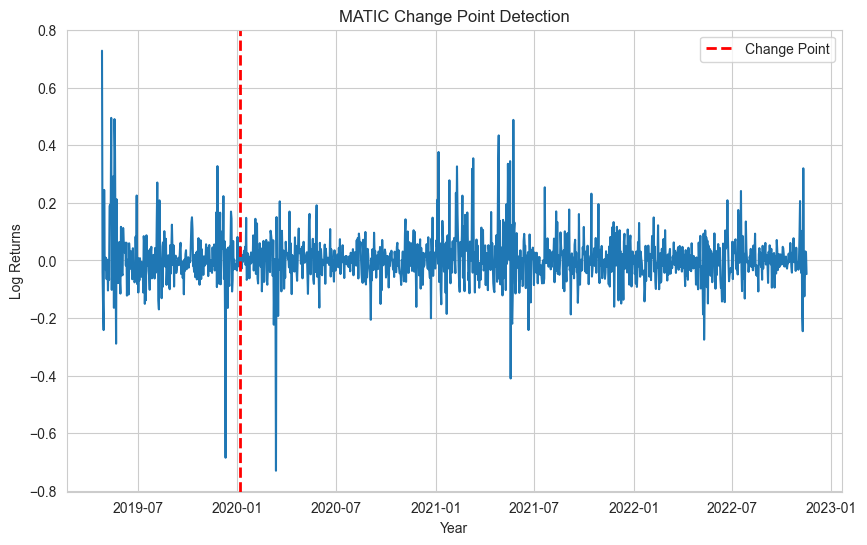

Change Point Date for DOT: 2021-04-30


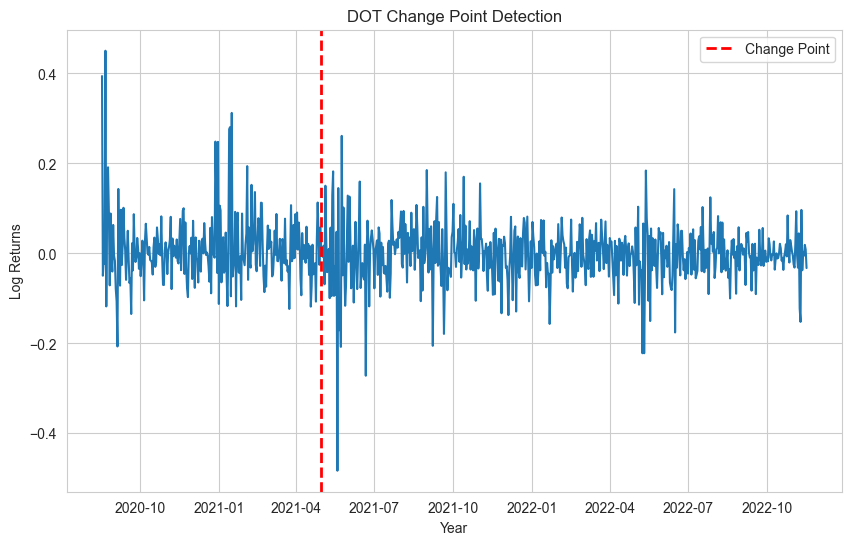

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


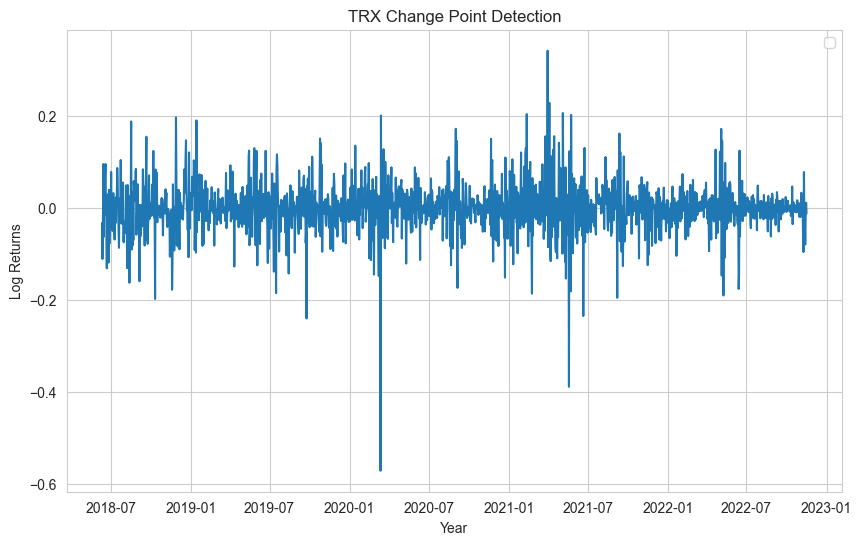

In [24]:
compute_display_change_points(rpt.Pelt(model="rbf"), data=data_resampled, coins=TOP_MKT_CAP)

## Binary Segmentation (BinSeg)

Change Point Date for BTC: 2018-04-29


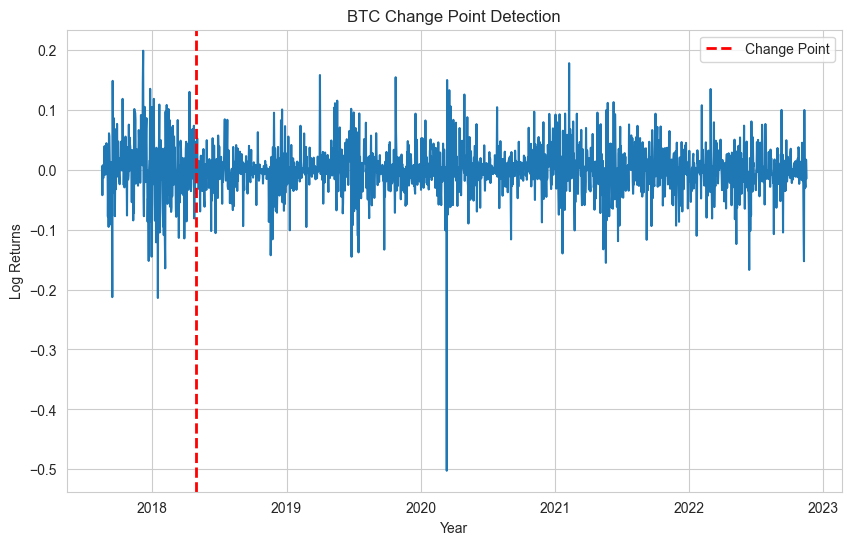

Change Point Date for ETH: 2018-04-29


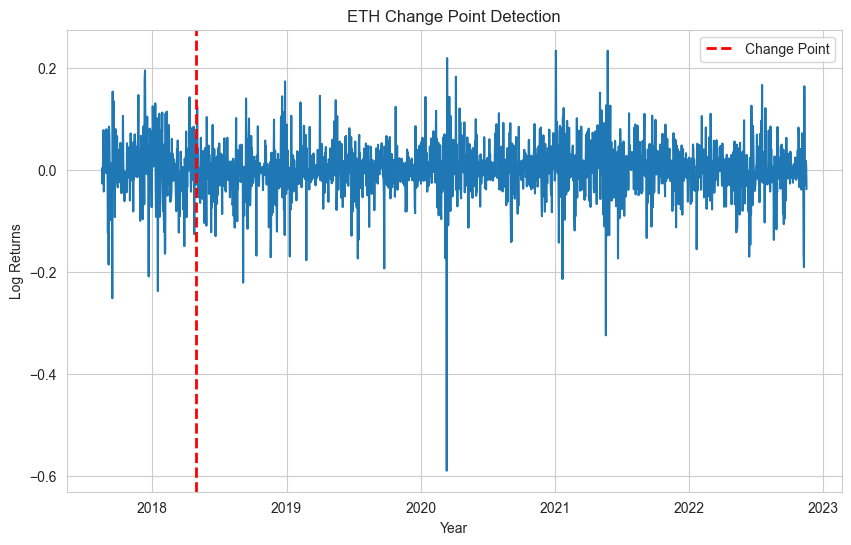

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


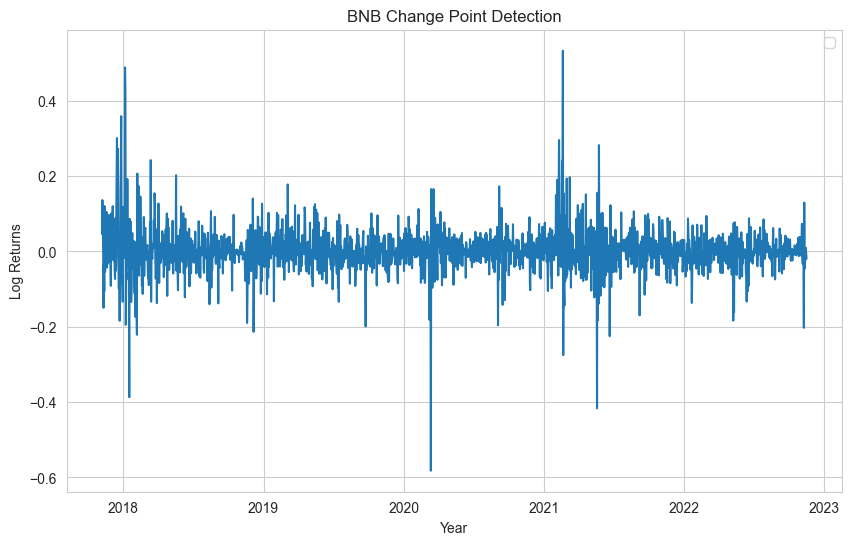

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


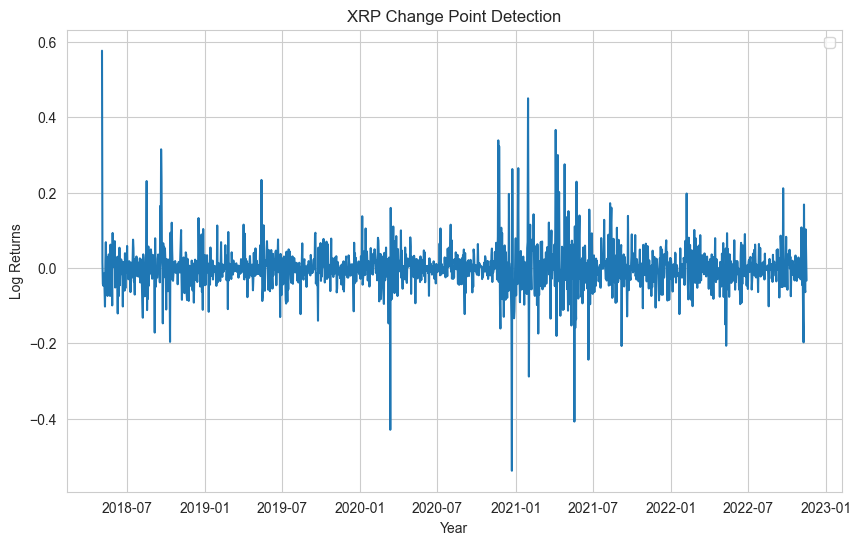

Change Point Date for DOGE: 2020-03-16


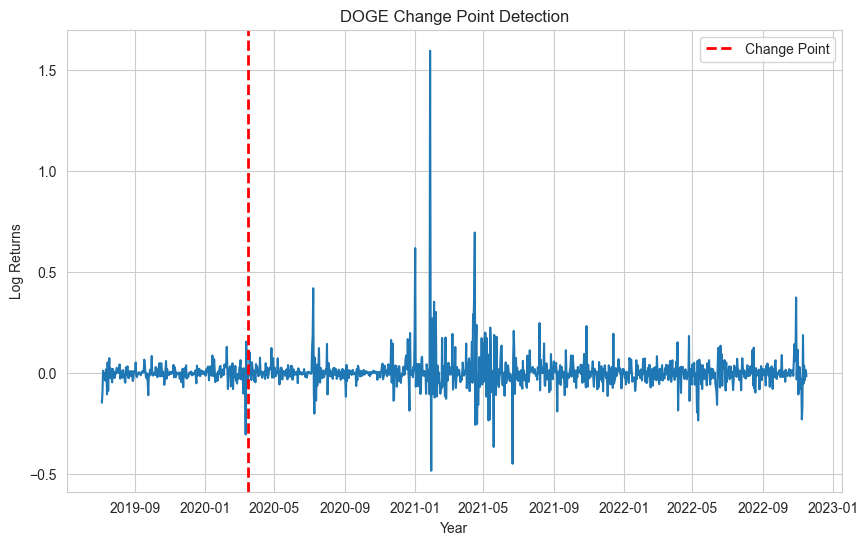

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


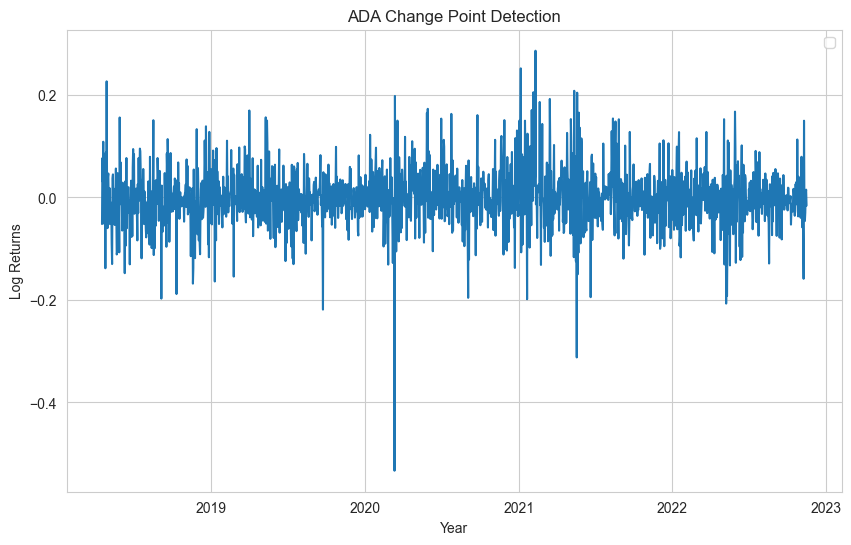

Change Point Date for MATIC: 2020-01-06


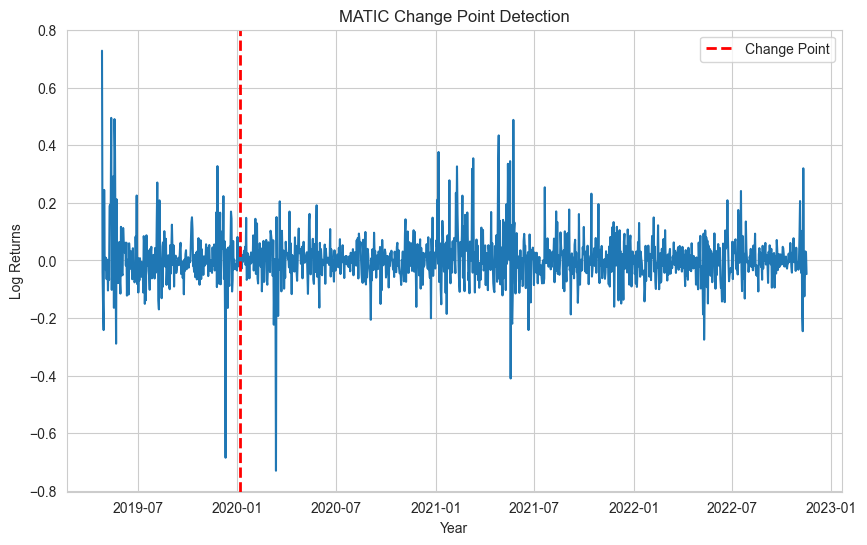

Change Point Date for DOT: 2021-04-30


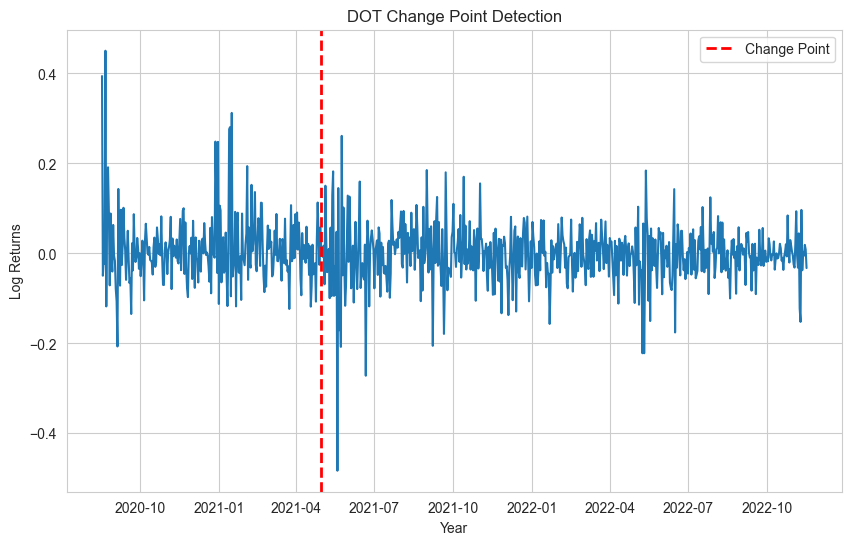

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


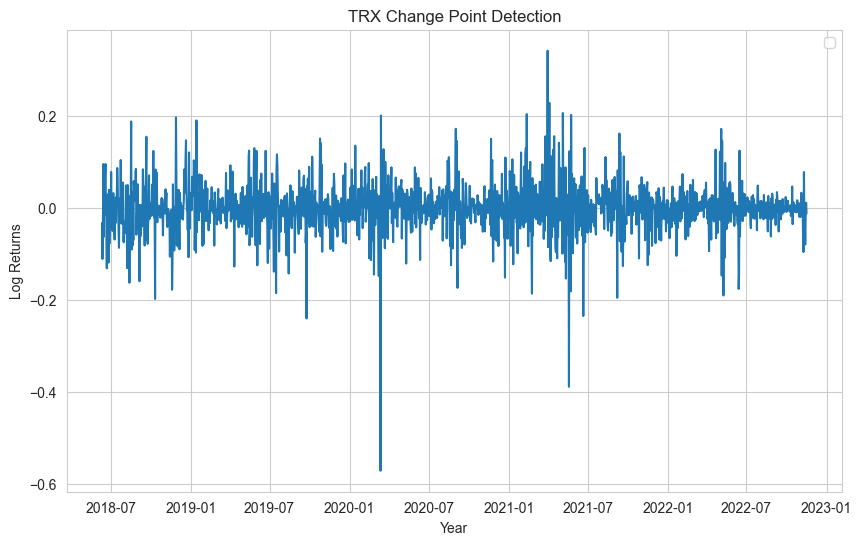

In [25]:
compute_display_change_points(rpt.Binseg(model='rbf'), data=data_resampled, coins=TOP_MKT_CAP)

## BottomUp

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


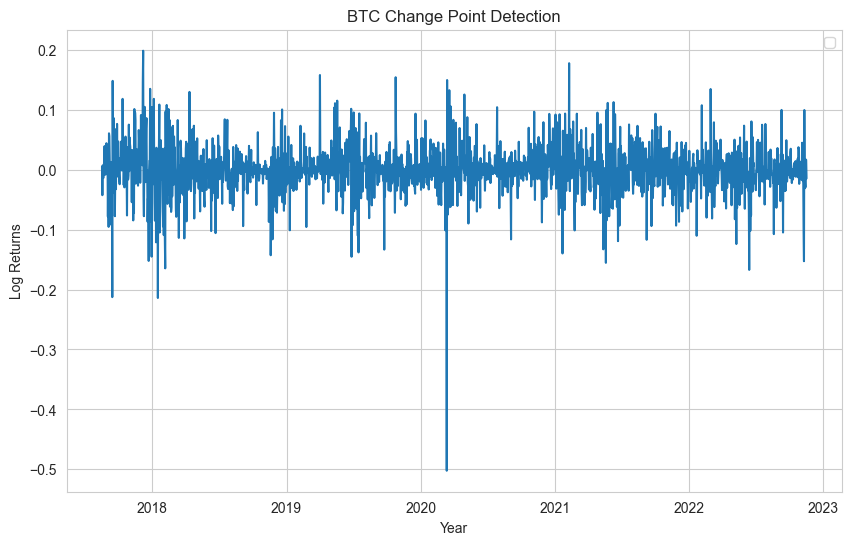

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


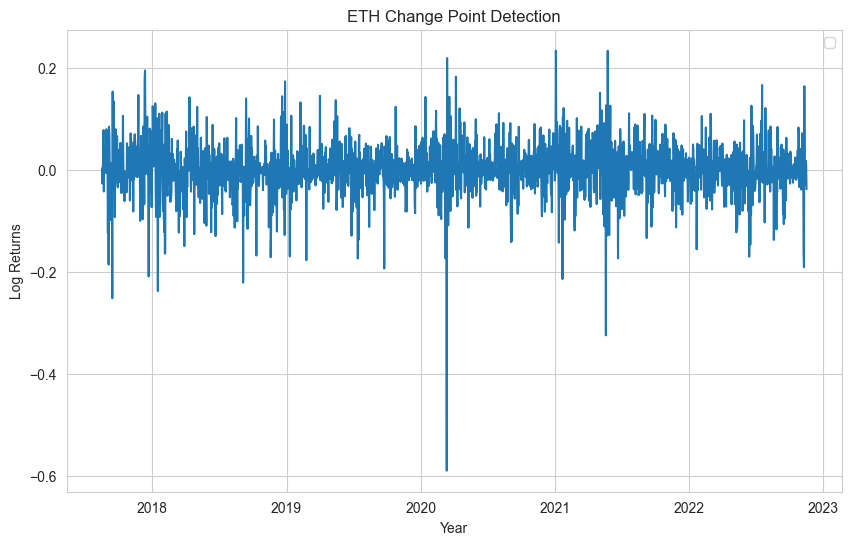

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


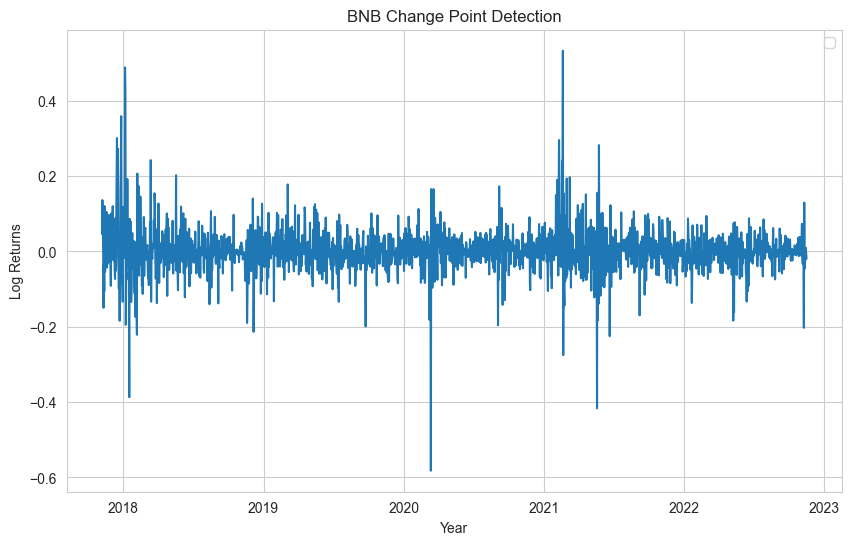

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


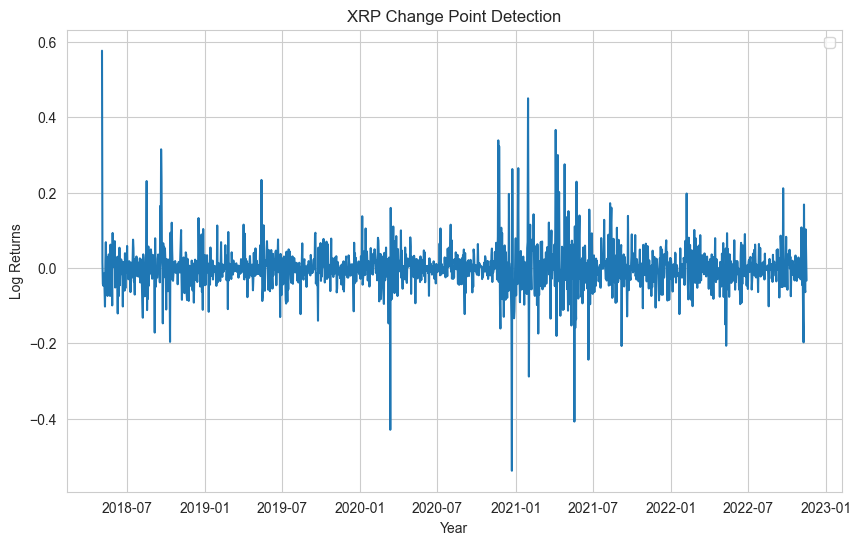

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


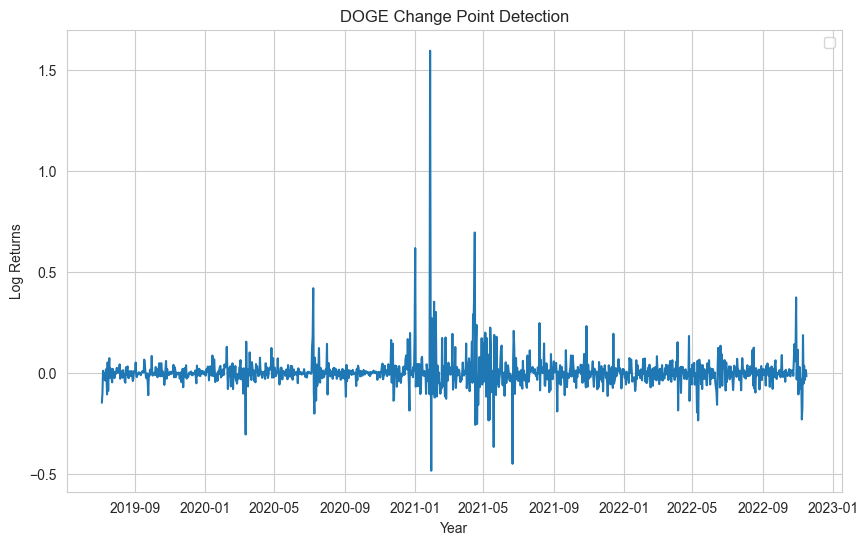

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


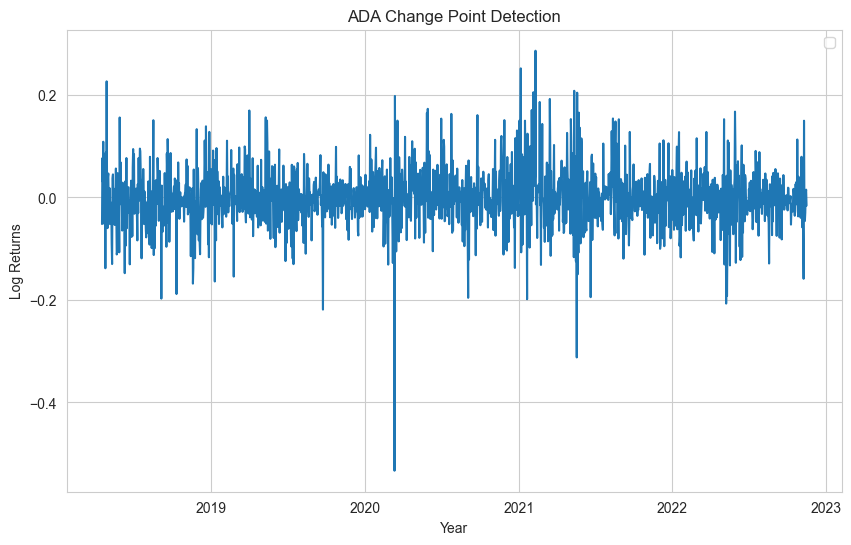

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


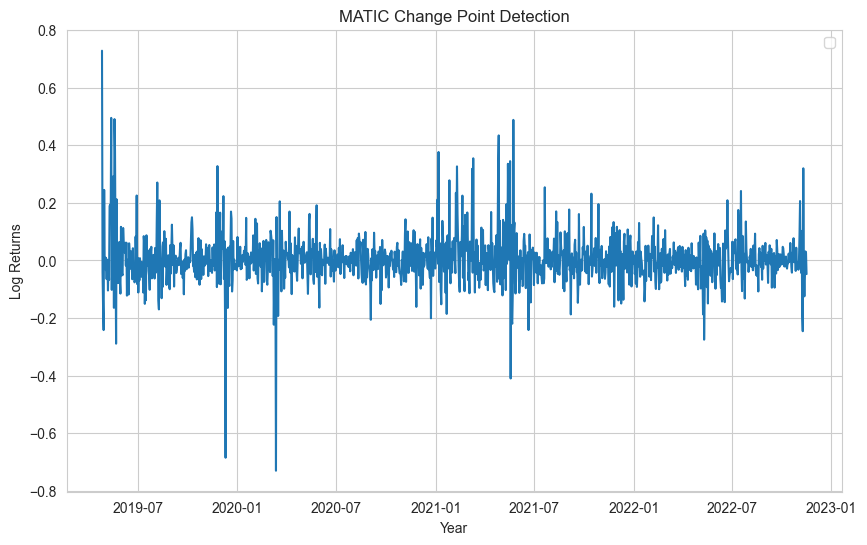

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


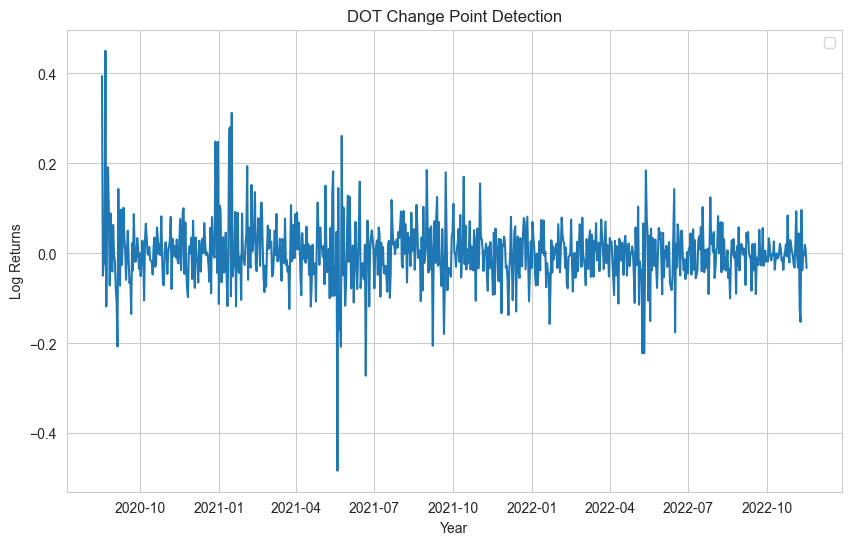

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


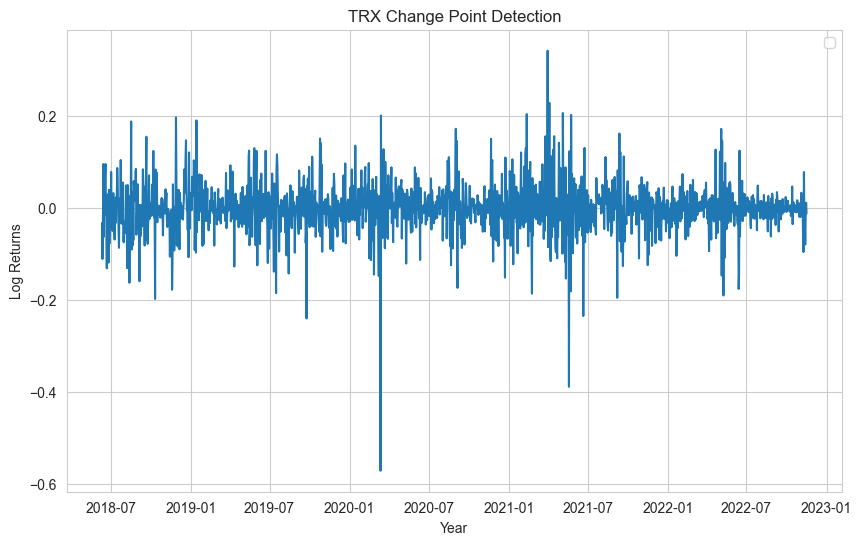

In [26]:
compute_display_change_points(rpt.BottomUp(model='rbf'), data=data_resampled, coins=TOP_MKT_CAP)

## Window based

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


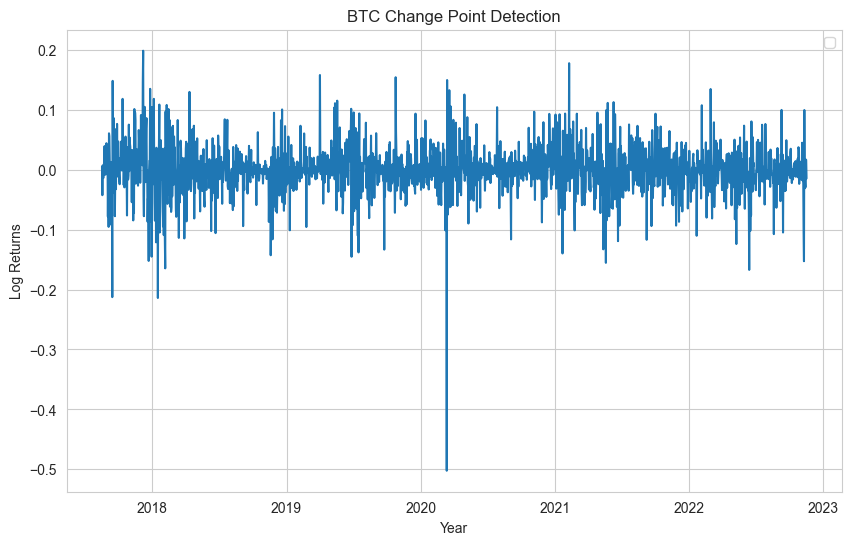

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


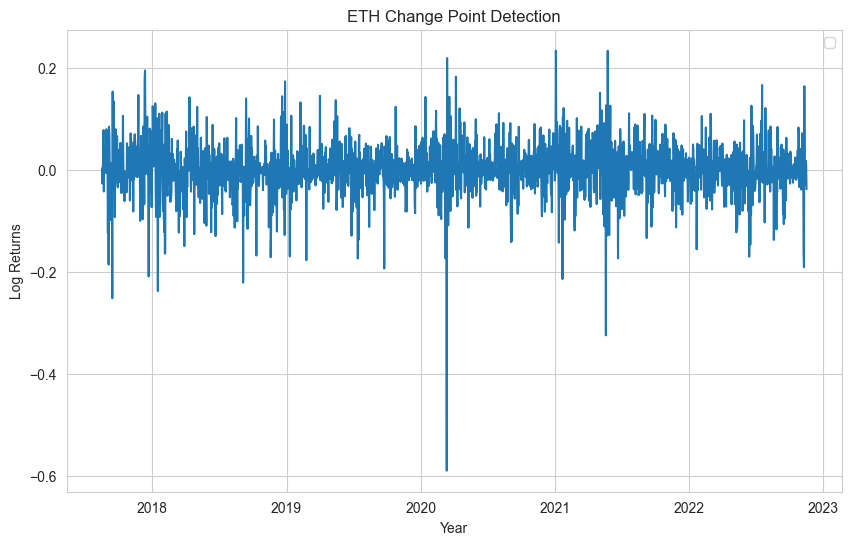

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


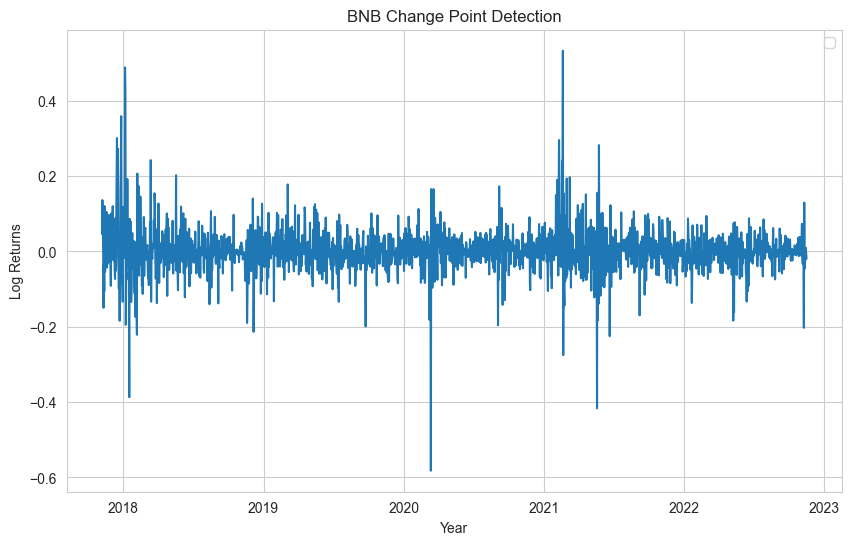

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


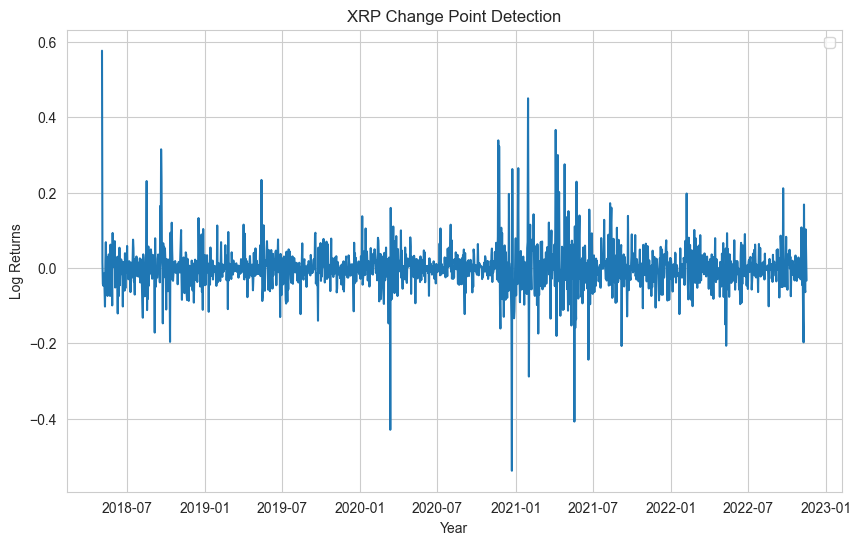

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


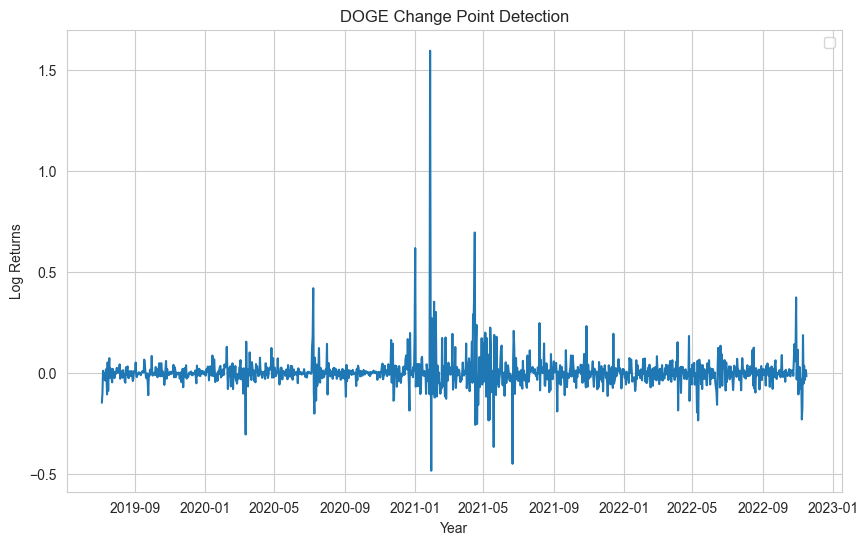

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


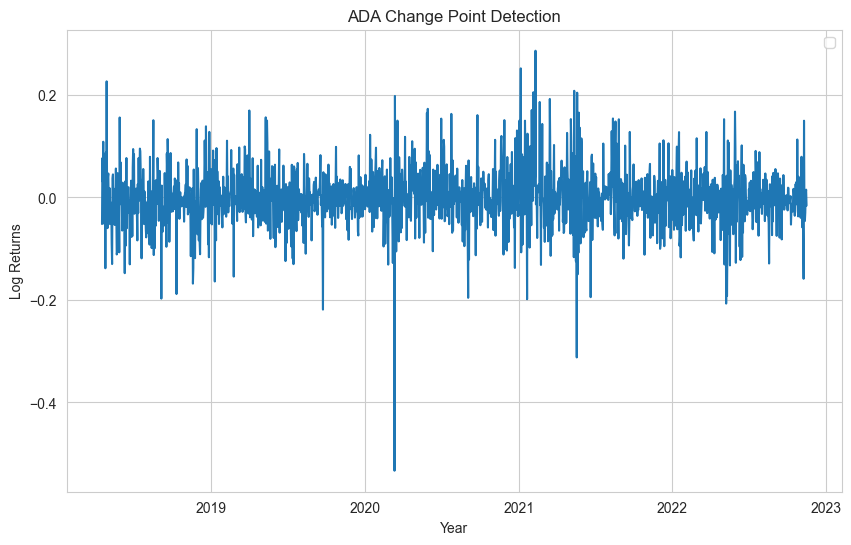

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


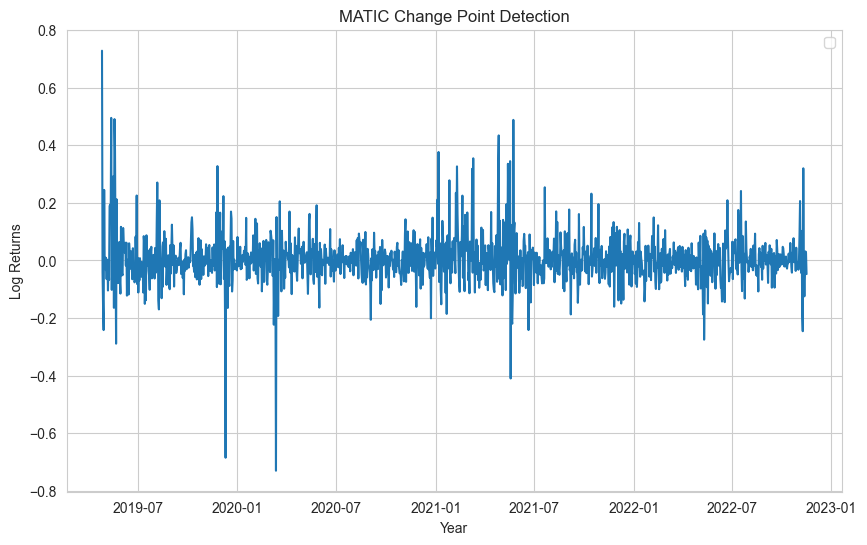

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


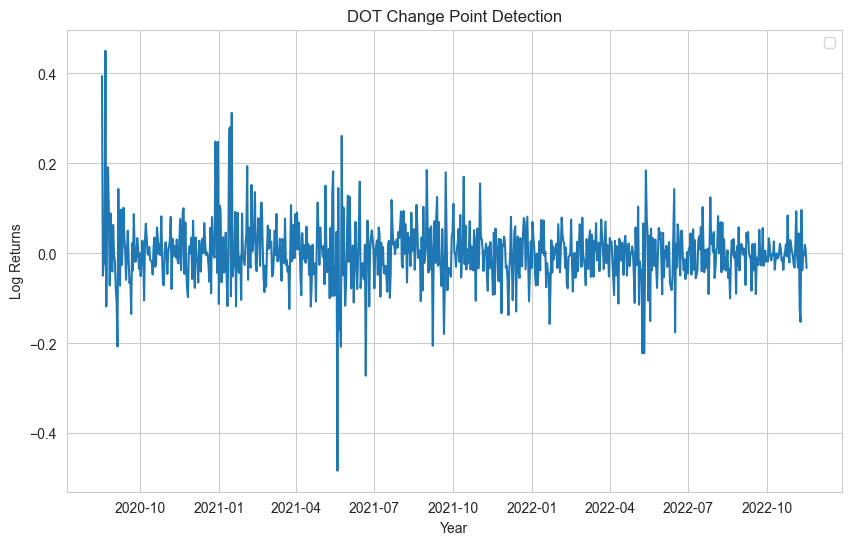

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


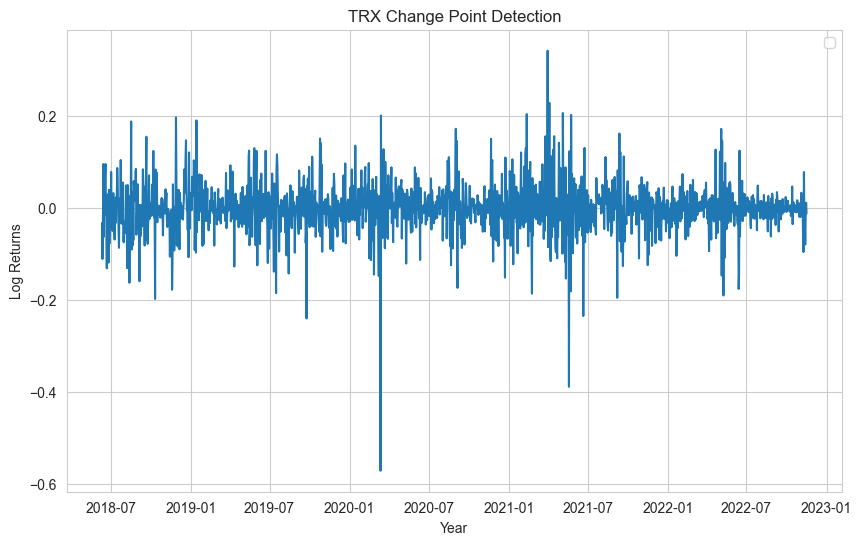

In [27]:
compute_display_change_points(rpt.Window(width=30, model='ar'), data=data_resampled, coins=TOP_MKT_CAP)